In [5]:
import pandas as pd
import pickle
import numpy as np
import re
import os
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt


In [2]:
# Define the column patterns
column_patterns = {
    'Time (s)': r'Time.*s',
    'Motor Speed (RPM)': r'Motor.*RPM',
    'Engine Speed (RPM)': r'Engine.*Speed.*RPM',
    'Throttle (%)': r'Throttle.*%',
    'Intake Temperature (C)': r'\s*Intake\s*Temp(?:erature)?\s*\(\s*C\s*\)',
    'Engine Coolant Temperature 1 (C)': r'\s*Engine\s*Coolant\s*(?:Temperature|Temp)\s*1?\s*\(\s*C\s*\)',
    'Engine Coolant Temperature 2 (C)': r'\s*Engine\s*Coolant\s*(?:Temperature|Temp)\s*2?\s*\(\s*C\s*\)',
    'Barometric Pressure (kpa)': r'Barometric.*Pressure.*kpa',
    'Fuel Trim': r'Fuel.*Trim',
    'Fuel Consumption (g/min)': r'Fuel.*Consumption.*g.*min',
    'Fuel Consumed (g)': r'Fuel.*Consumed.*g',
    'Expected Max Power (W)': r'Expected.*Max.*Power.*W',
    'Bus Voltage (V)': r'Bus.*Voltage.*V',
    'Battery Current (A)': r'Battery.*Current.*A',
    'Power Generated (W)': r'Power.*Generated.*W',
    'Inverter Temperature (C)': r'\s*Inverter\s*(?:Temperature|MAX)\s*\(\s*C\s*\)',
    'Target Fuel Pressure (bar)': r'Target.*Fuel.*Pressure.*bar',
    'Fuel Pressure (bar)': r'Fuel.*Pressure.*bar',
    'Fuel Pump Speed (RPM)': r'Fuel.*Pump.*Speed.*RPM',
    'Cooling Pump Speed (RPM)': r'Cooling.*Pump.*Speed.*RPM',
}

# Function to standardize columns
def standardize_columns(df, column_patterns):
    standardized_columns = {}
    for standard_col, pattern in column_patterns.items():
        for col in df.columns:
            if re.match(pattern, col, re.IGNORECASE):
                standardized_columns[col] = standard_col
                break
    df = df.rename(columns=standardized_columns)
    return df[list(column_patterns.keys())]

# Function to preprocess the data
def preprocess(df):
    df = df.copy()
    df = standardize_columns(df, column_patterns)
    reference_date = pd.to_datetime('1970-01-01')
    df['Time (s)'] = reference_date + pd.to_timedelta(df['Time (s)'], unit='s')
    df = df.set_index('Time (s)')
    df = df.dropna()
    return df

In [3]:
# Load the model
with open('timeseries_kmeans_model2.pkl', 'rb') as f:
    model = pickle.load(f)

In [6]:
# Read the data
file_path = os.path.join('logs', 'selected', '-1', '50 throttle not enough power(annotated).xlsx')
df = pd.read_excel(file_path)

In [7]:
# Process the first n rows of the data
df_initial = df.iloc[:2000]
df_initial_processed = preprocess(df_initial)

In [8]:
# Convert the initial data to time series dataset
time_series_data = [df_initial_processed.values]
X_initial = to_time_series_dataset(time_series_data)

In [9]:
with open('time_series_resampler.pkl', 'rb') as f :
    time_series_resampler = pickle.load(f)
    
with open('time_series_scaler_minmax.pkl', 'rb') as f:
    time_series_scaler_minmax = pickle.load(f)

In [10]:
# Resample and scale the initial data

    
X_initial_scaled = time_series_resampler.transform(X_initial)
X_initial_scaled = time_series_scaler_minmax.transform(X_initial_scaled)
X_initial_scaled.shape

(1, 5000, 19)

In [11]:
# Predict the initial cluster labels
labels_initial = model.predict(X_initial_scaled)
labels_initial.shape

(1,)

In [15]:
# Function to print cluster labels with explanations for changes
def print_cluster_labels_with_explanations(X_scaled, current_label, prev_label, df):
    time_index = df.index[-1].time()
    print(f'Time series index: {time_index}, Cluster label: {current_label}')
    if current_label != prev_label:
        curr_df = df.iloc[-1]
        prev_df = df.iloc[-2]
        
        # Identify the column with the most significant change     
        most_changed_col_index = np.abs(X_scaled[-1] - X_scaled[-2]).argmax()
        most_changed_col = str(df.columns[most_changed_col_index])
        explanation = f"Probable reason: Significant change in {most_changed_col} from {prev_df.iloc[most_changed_col_index]} to {curr_df.iloc[most_changed_col_index]}."
        
        print(f'Cluster label changed from {prev_label} to {current_label}.\n========Explanation: {explanation}==========')

Time series index: 00:08:23.790000, Cluster label: 1


In [17]:
prev_label = int(labels_initial)
# Print the initial cluster labels with explanations
print_cluster_labels_with_explanations(
    X_initial_scaled[0], 
    int(labels_initial), 
    prev_label, 
    df_initial_processed
)

#Append each row after 1000 rows of the initial data and predict labels

for i in range(2000, len(df)):
    df_extended = df.iloc[:i+1]
    df_extended_processed = preprocess(df_extended)
    
    # Convert to time series dataset
    time_series_data = [df_extended_processed.values]
    X_extended = to_time_series_dataset(time_series_data)
    
    # Resample and scale the data
    X_extended_scaled = time_series_resampler.transform(X_extended)
    X_extended_scaled = time_series_scaler_minmax.fit_transform(X_extended_scaled)
    
    # Predict cluster labels
    labels_extended = model.predict(X_extended_scaled)
    
    # Print the cluster labels with explanations
    scaling_factor = 1000 / len(df_extended_processed)
    if prev_label != int(labels_extended) :
        print_cluster_labels_with_explanations(
            X_extended_scaled[0], 
            int(labels_extended), 
            prev_label, 
            df_extended_processed
        )
    
    prev_label = int(labels_extended)

Time series index: 00:08:23.790000, Cluster label: 1
Time series index: 00:16:06.790000, Cluster label: 2
Cluster label changed from 1 to 2.
========Explanation: Probable reason: Significant change in Fuel Pump Speed (RPM) from 2390.0 to 3815.0.==========
Time series index: 00:16:32.040000, Cluster label: 1
Cluster label changed from 2 to 1.
========Explanation: Probable reason: Significant change in Fuel Pump Speed (RPM) from 3957.0 to 2190.0.==========
Time series index: 00:16:34.290000, Cluster label: 2
Cluster label changed from 1 to 2.
========Explanation: Probable reason: Significant change in Battery Current (A) from 23.08 to 7.74.==========


In [27]:
reference_date = pd.to_datetime('1970-01-01')
loc_indices = reference_date + pd.to_timedelta(['00:16:06.790000', '00:16:32.040000', '00:16:34.290000'])

In [41]:
def get_indices_around_loc(df, loc_indices, offset=5):
    all_indices = []
    for loc in loc_indices:
        pos = df.index.get_loc(loc)
        start = max(0, pos - offset)  # Ensure start is not less than 0
        end = min(len(df), pos + offset + 1)  # Ensure end does not exceed DataFrame length
        indices = range(start, end)
        all_indices.extend(indices)
    return list(set(all_indices))  # Remove duplicates and convert to list

# Get the indices
indices = get_indices_around_loc(df_extended_processed, loc_indices, offset=5)

In [66]:
def highlight_rows(x):
    if x.name in loc_indices:
        return ['background-color: lightcoral']*len(x)
    else:
        return ['']*len(x)

# Apply the highlighting function
styled_df = df_extended_processed.iloc[indices].style.apply(highlight_rows, axis=1)

In [67]:
styled_df

,Motor Speed (RPM),Engine Speed (RPM),Throttle (%),Intake Temperature (C),Engine Coolant Temperature 1 (C),Engine Coolant Temperature 2 (C),Barometric Pressure (kpa),Fuel Trim,Fuel Consumption (g/min),Fuel Consumed (g),Expected Max Power (W),Bus Voltage (V),Battery Current (A),Power Generated (W),Inverter Temperature (C),Target Fuel Pressure (bar),Fuel Pressure (bar),Fuel Pump Speed (RPM),Cooling Pump Speed (RPM)
Time (s),,,,,,,,,,,,,,,,,,,
1970-01-01 00:16:05.540000,5049.000000,4898,45,37,36,37,99,1.000000,26.200000,18,0,49.720000,-1.590000,-28,36,3.100000,3.100000,2019,4323
1970-01-01 00:16:05.790000,4983.600000,5037,45,37,36,37,99,1.000000,27.300000,18,0,49.820000,1.240000,49,36,3.100000,3.000000,2077,4332
1970-01-01 00:16:06.040000,5047.100000,4885,44,37,36,37,99,1.000000,26.400000,18,0,49.820000,-5.720000,133,36,3.100000,3.100000,1911,4322
1970-01-01 00:16:06.290000,4989.800000,4910,44,37,37,37,99,1.000000,27.200000,18,0,49.730000,3.400000,-60,36,3.100000,3.100000,1922,4340
1970-01-01 00:16:06.540000,4975.300000,4889,44,38,37,37,100,1.000000,26.000000,18,0,49.730000,-0.760000,-18,36,3.100000,2.400000,2390,4333
1970-01-01 00:16:06.790000,5053.600000,5102,44,38,37,37,100,1.000000,27.200000,18,0,49.850000,-2.760000,67,36,3.100000,1.600000,3815,4330
1970-01-01 00:16:07.040000,4953.000000,4978,45,38,37,37,100,1.000000,26.800000,18,0,49.850000,3.070000,-117,36,3.100000,1.300000,4788,4334
1970-01-01 00:16:07.290000,5046.600000,5015,45,38,37,37,100,1.000000,27.100000,19,0,49.770000,-0.970000,-49,36,3.100000,0.900000,4832,4352
1970-01-01 00:16:07.540000,4999.500000,4804,41,38,37,37,100,1.000000,24.900000,19,0,49.770000,2.560000,-49,36,3.100000,0.800000,4802,4351


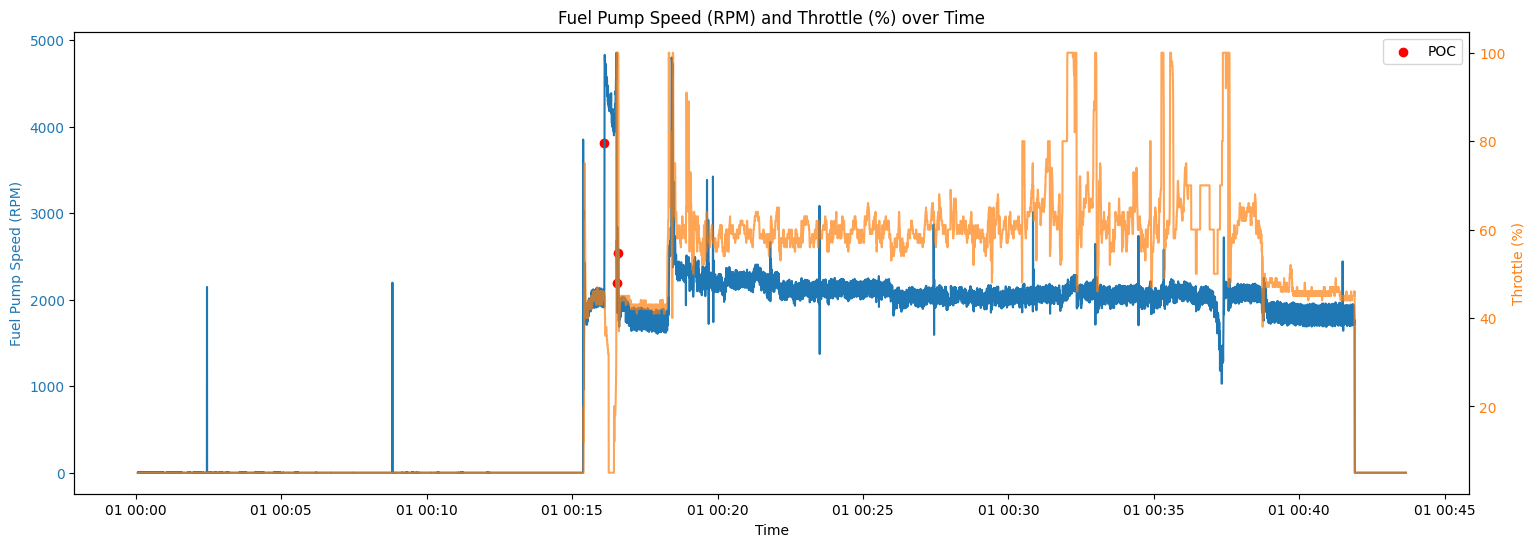

In [97]:
# Plotting the data
fig, ax1 = plt.subplots(figsize=(18, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Fuel Pump Speed (RPM)', color=color)
ax1.plot(df_extended_processed.index, df_extended_processed['Fuel Pump Speed (RPM)'], color=color)
ax1.scatter(loc_indices, df_extended_processed.loc[loc_indices, 'Fuel Pump Speed (RPM)'], c='red', label='POC')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Throttle (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_extended_processed.index, df_extended_processed['Throttle (%)'], color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Fuel Pump Speed (RPM) and Throttle (%) over Time')
ax1.legend()
plt.show()